<a href="https://colab.research.google.com/github/pylabview/Applying_Advanced_Transformations_Core/blob/main/Assignment_3_Variational_Autoencoders_VAEs_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variationa Encoders

## 1️⃣ Theory Questions

## Assignment 3: Variational Autoencoders — Theory Questions

### Q1: Why is the KL Divergence term important in the VAE loss function?

The Kullback–Leibler (KL) divergence term,  serves as a regularization mechanism in the VAE loss function. It encourages the approximate posterior
, produced by the encoder, to stay close to the prior distribution

 typically a standard normal. This ensures that:

- The latent space remains continuous and well-structured, enabling smooth interpolation and sampling.
- The model avoids overfitting by discouraging overly complex or disjoint latent representations.
- Generative sampling from the prior results in valid outputs, as the decoder is trained on latent codes drawn from a distribution close to the prior.

Without this term, the encoder might collapse into encoding inputs at arbitrary locations in the latent space, leading to disorganized and discontinuous manifolds.

**References:**

- Kingma & Welling, *Auto-Encoding Variational Bayes*, arXiv:1312.6114 [[Paper]](https://arxiv.org/abs/1312.6114)  
- Ye et al., *Distribution Matching VAE*, arXiv:2512.07778  
- Lee et al., *Latent Diffusion Models with Masked Autoencoders*, ICCV 2025  
- Stanford CS231n Lecture Notes on Generative Models

---

### Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

The reparameterization trick rewrites the stochastic sampling of the latent variable
<br>
$$
z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$
<br>


This reformulation isolates the stochasticity in \( \epsilon \), which is independent of the model parameters. The result is a differentiable computation graph with respect to \( \phi \), enabling gradient-based optimization via backpropagation. This approach offers low-variance gradient estimates and allows VAEs to be trained using standard gradient descent techniques.

**References:**

- Kingma & Welling, *Auto-Encoding Variational Bayes*, arXiv:1312.6114  
- Doersch, *Tutorial on Variational Autoencoders*, arXiv:1606.05908  
- Stanford CS231n Lecture Notes on Generative Models

---

### Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?

A VAE maps inputs to distributions over latent variables rather than fixed encodings. This design choice provides several advantages:

- **Uncertainty Modeling:** The encoder reflects uncertainty in its representation, which is useful for ambiguous or noisy inputs.
- **Smooth Latent Space:** Probabilistic mappings prevent the latent space from forming disconnected clusters, facilitating interpolation and sampling.
- **Generative Capability:** Sampling from the prior or learned distributions leads to plausible outputs, which wouldn't be feasible with deterministic encodings.
- **Variational Inference:** The ELBO objective requires modeling \( q_\phi(z|x) \) as a distribution to approximate the intractable true posterior.

In contrast, deterministic latent codes do not support sampling-based generation and often lead to poor generalization.

**References:**

- Doersch, *Tutorial on Variational Autoencoders*, arXiv:1606.05908  
- Ye et al., *Distribution Matching VAE*, arXiv:2512.07778  
- Lee et al., *Latent Diffusion Models with Masked Autoencoders*, ICCV 2025

---

### Q4: What role does KL Divergence play in ensuring a smooth latent space?

The KL divergence term encourages each latent distribution \( q_\phi(z|x) \) to remain close to the global prior \( p(z) \). This results in:

- **Overlap Among Latent Distributions:** Ensures that latent codes from different inputs share regions in the latent space.
- **Continuity:** Enables smooth transitions and interpolation between encodings.
- **Robust Generation:** Any point sampled from the latent space is likely to correspond to a meaningful output.
- **Decoder Robustness:** Forces the decoder to generalize across neighborhoods in latent space, not just point estimates.

By shaping the latent space into a single, coherent manifold, the KL term guarantees that the space supports generation, interpolation, and representation learning.

**References:**

- Kingma & Welling, *Auto-Encoding Variational Bayes*, arXiv:1312.6114  
- Shrivastava et al., *Latent Space Characterization of Autoencoder Variants*, arXiv:2412.04755  
- Lee et al., *Latent Diffusion Models with Masked Autoencoders*, ICCV 2025


## 2️⃣ Coding Task

### Task1

>Modify the VAE architecture to use convolutional layers for both the encoder and decoder, and train it on the CIFAR-10 dataset. This modification will allow the model to capture spatial relationships within images more effectively, improving its ability to generate high-quality images. After training, compare the generated images with those from a fully connected VAE.

References / Citations<br/>
- Lightning-Universe. (n.d.). lightning-bolts [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/Lightning-Universe/lightning-bolts

- Lightning-Universe. (n.d.). basic_vae_module.py (lightning-bolts) [Source code]. GitHub. Retrieved January 31, 2026, from https://github.com/Lightning-Universe/lightning-bolts/blob/master/src/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py

- pi-tau. (n.d.). vae [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/pi-tau/vae

- SashaMalysheva. (n.d.). Pytorch-VAE [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/SashaMalysheva/Pytorch-VAE


In [ ]:
#### Cell 1.1 Imports + Reproducibility
import os, math, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

from tqdm.auto import tqdm


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
### Cell 1.2 — CIFAR-10 DataLoaders
BATCH_SIZE = 128
NUM_WORKERS = 2  # can be increase

transform = T.Compose([
    T.ToTensor(),  # outputs in [0,1]
])

train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))

print("Train batches:", len(train_loader), "| Test batches:", len(test_loader))


100%|██████████| 170M/170M [00:02<00:00, 78.7MB/s]


Train batches: 391 | Test batches: 79


In [ ]:
### Cell 1.3 — Helper Functions (Loss, Sampling, Plotting)
def kl_divergence(mu, logvar):
    # KL(q(z|x) || p(z)) where p(z)=N(0,1)
    # returns sum over batch and latent dims
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def recon_loss_fn(recon_x, x, kind="mse"):
    # returns sum over all pixels + batch
    if kind == "bce":
        return F.binary_cross_entropy(recon_x, x, reduction="sum")
    return F.mse_loss(recon_x, x, reduction="sum")

def vae_loss(recon_x, x, mu, logvar, beta=1.0, recon_kind="mse"):
    recon = recon_loss_fn(recon_x, x, kind=recon_kind)
    kl = kl_divergence(mu, logvar)
    total = recon + beta * kl
    # Return per-batch average (more readable)
    bs = x.size(0)
    return total / bs, recon / bs, kl / bs

@torch.no_grad()
def sample_images(model, latent_dim, n=8):
    model.eval()
    z = torch.randn(n, latent_dim, device=device)
    x = model.decode(z).clamp(0, 1)
    return x

@torch.no_grad()
def reconstruct_images(model, x):
    model.eval()
    recon, mu, logvar = model(x)
    return recon.clamp(0, 1)

def show_grid(images, title="", nrow=8, figsize=(10, 4)):
    # images: (B,3,32,32)
    grid = make_grid(images.cpu(), nrow=nrow, padding=2)
    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(title)
    plt.show()


In [ ]:
### Cell 1.4 Cell 4 — Baseline: Fully-Connected VAE (MLP)
class FCVAE(nn.Module):
    def __init__(self, latent_dim=128, hidden_dims=(1024, 512)):
        super().__init__()
        self.latent_dim = latent_dim
        in_dim = 3 * 32 * 32

        h1, h2 = hidden_dims
        self.enc = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(inplace=True),
            nn.Linear(h1, h2),
            nn.ReLU(inplace=True),
        )
        self.fc_mu = nn.Linear(h2, latent_dim)
        self.fc_logvar = nn.Linear(h2, latent_dim)

        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim, h2),
            nn.ReLU(inplace=True),
            nn.Linear(h2, h1),
            nn.ReLU(inplace=True),
            nn.Linear(h1, in_dim),
        )

    def encode(self, x):
        x = x.view(x.size(0), -1)
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        out = self.dec_fc(z)
        out = torch.sigmoid(out)  # output in [0,1]
        return out.view(z.size(0), 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
### Cell 1.5 — Task Model: Convolutional VAE (Conv Encoder + Conv Decoder)
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim

        # 32x32 -> 16x16 -> 8x8 -> 4x4 -> 2x2
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # (B,32,16,16)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1),  # (B,64,8,8)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1), # (B,128,4,4)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),# (B,256,2,2)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.enc_out_dim = 256 * 2 * 2
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, self.enc_out_dim)

        # 2x2 -> 4x4 -> 8x8 -> 16x16 -> 32x32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (B,128,4,4)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (B,64,8,8)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (B,32,16,16)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # (B,3,32,32)
            nn.Sigmoid(),  # output in [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(z.size(0), 256, 2, 2)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
### Cel 1.6 — Training / Evaluation Loop
def train_vae(model, train_loader, test_loader, epochs=10, lr=2e-4, beta=1.0, recon_kind="mse"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    use_amp = (device.type == "cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    history = {"train_total": [], "train_recon": [], "train_kl": [],
               "test_total": [], "test_recon": [], "test_kl": []}

    for epoch in range(1, epochs + 1):
        # ---- train ----
        model.train()
        t_total = t_recon = t_kl = 0.0
        n_train = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]", leave=False)
        for x, _ in pbar:
            x = x.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                recon, mu, logvar = model(x)
                loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta=beta, recon_kind=recon_kind)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            bs = x.size(0)
            t_total += loss.item() * bs
            t_recon += rloss.item() * bs
            t_kl += kl.item() * bs
            n_train += bs

            pbar.set_postfix({"loss": loss.item(), "recon": rloss.item(), "kl": kl.item()})

        train_total = t_total / n_train
        train_recon = t_recon / n_train
        train_kl = t_kl / n_train

        # ---- eval ----
        model.eval()
        v_total = v_recon = v_kl = 0.0
        n_test = 0
        with torch.no_grad():
            for x, _ in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} [eval]", leave=False):
                x = x.to(device, non_blocking=True)
                recon, mu, logvar = model(x)
                loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta=beta, recon_kind=recon_kind)

                bs = x.size(0)
                v_total += loss.item() * bs
                v_recon += rloss.item() * bs
                v_kl += kl.item() * bs
                n_test += bs

        test_total = v_total / n_test
        test_recon = v_recon / n_test
        test_kl = v_kl / n_test

        history["train_total"].append(train_total)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)
        history["test_total"].append(test_total)
        history["test_recon"].append(test_recon)
        history["test_kl"].append(test_kl)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Train: total={train_total:.4f}, recon={train_recon:.4f}, kl={train_kl:.4f} | "
              f"Test: total={test_total:.4f}, recon={test_recon:.4f}, kl={test_kl:.4f}")

    return history


In [ ]:
#### Cell 1.7 — Train FC-VAE and Conv-VAE
LATENT_DIM = 128
EPOCHS = 50          # try 5 for a quick run, 20-50 for better samples
LR = 2e-4
BETA = 1.5           # classic VAE; trying 1 - 0.5 or 2.0 v=cane be tweaked to see effect
RECON = "mse"        # "mse" or "bce" (MSE tends to behave better for natural images)

fc_vae = FCVAE(latent_dim=LATENT_DIM)
conv_vae = ConvVAE(latent_dim=LATENT_DIM)

print("Training Fully-Connected VAE...")
hist_fc = train_vae(fc_vae, train_loader, test_loader,
                    epochs=EPOCHS, lr=LR, beta=BETA, recon_kind=RECON)

print("\nTraining Convolutional VAE...")
hist_conv = train_vae(conv_vae, train_loader, test_loader,
                      epochs=EPOCHS, lr=LR, beta=BETA, recon_kind=RECON)


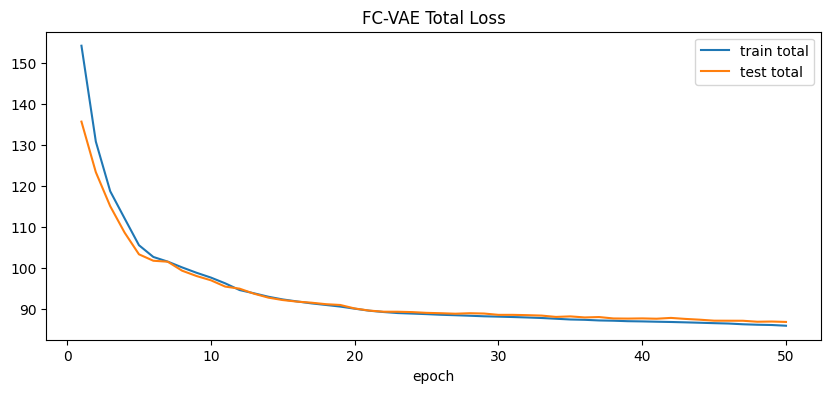

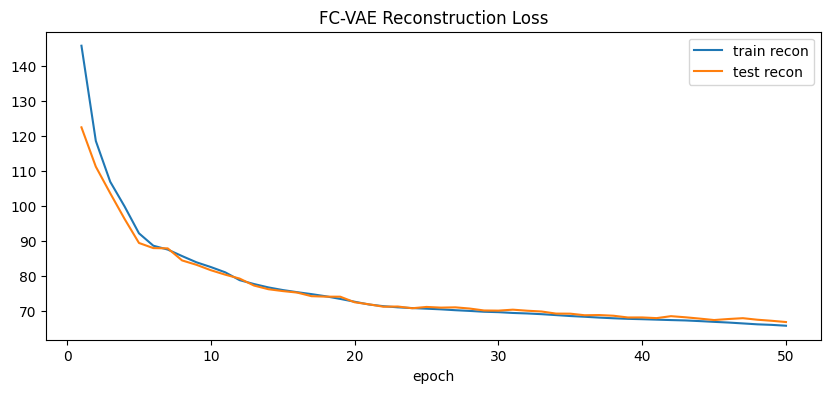

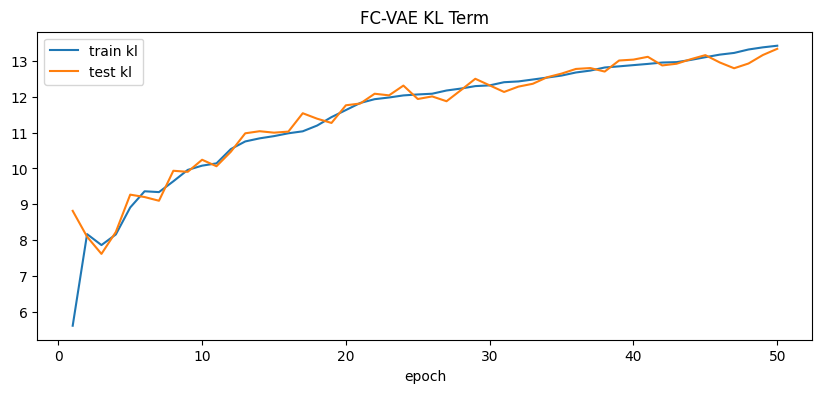

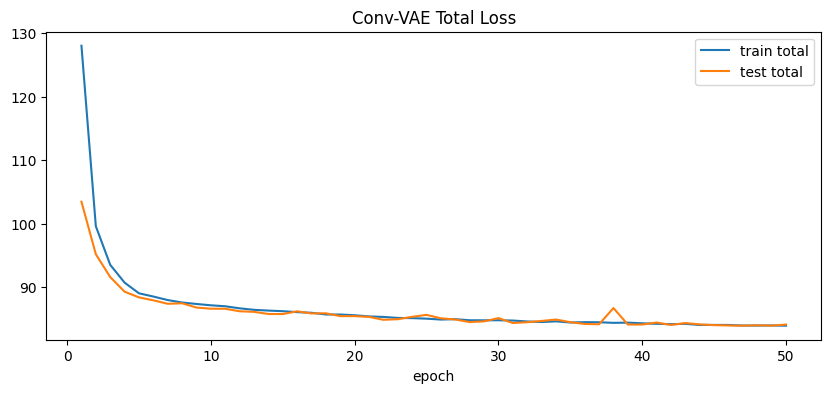

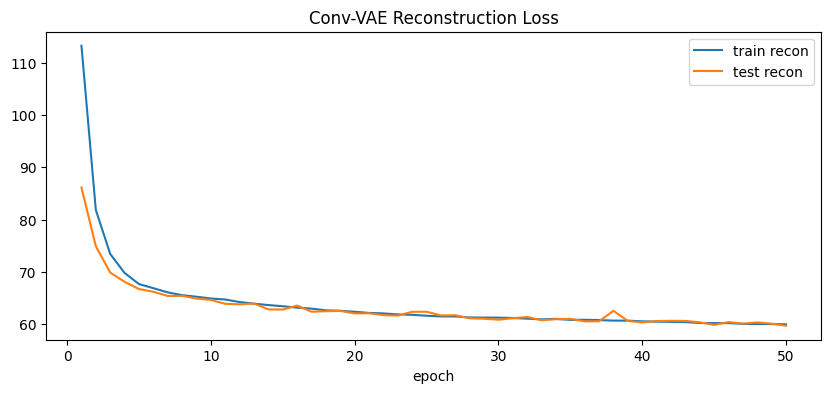

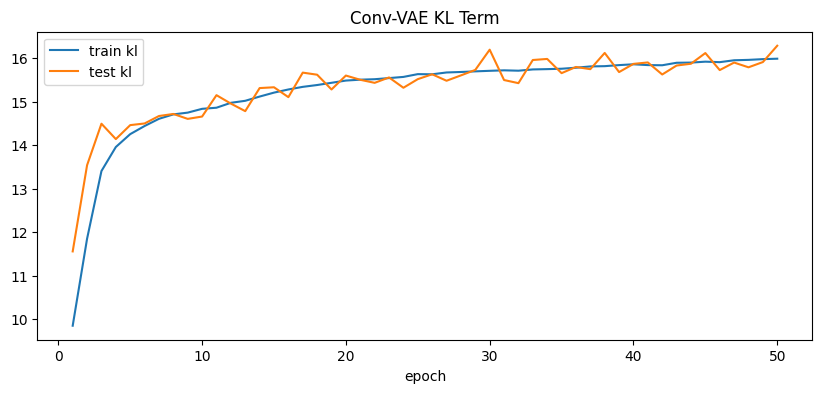

In [ ]:
### Cell 1.8 — Plot Loss Curves (Optional but Nice)
def plot_history(hist, title_prefix=""):
    xs = np.arange(1, len(hist["train_total"]) + 1)

    plt.figure(figsize=(10,4))
    plt.plot(xs, hist["train_total"], label="train total")
    plt.plot(xs, hist["test_total"], label="test total")
    plt.title(f"{title_prefix} Total Loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(xs, hist["train_recon"], label="train recon")
    plt.plot(xs, hist["test_recon"], label="test recon")
    plt.title(f"{title_prefix} Reconstruction Loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(xs, hist["train_kl"], label="train kl")
    plt.plot(xs, hist["test_kl"], label="test kl")
    plt.title(f"{title_prefix} KL Term")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

plot_history(hist_fc, "FC-VAE")
plot_history(hist_conv, "Conv-VAE")


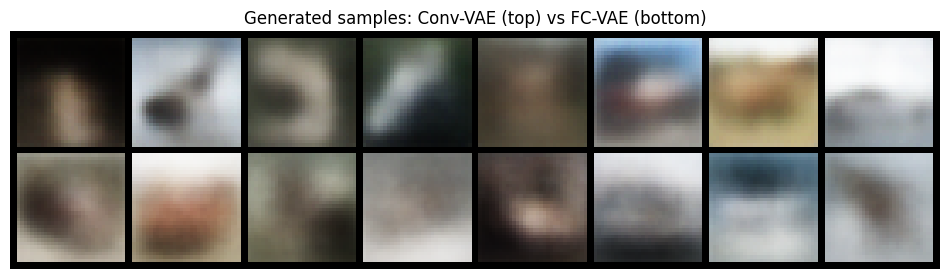

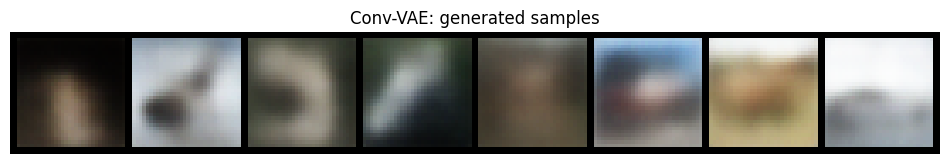

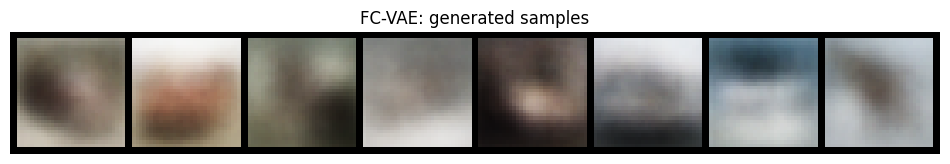

In [ ]:
#### Cell 1.9 — Compare Generated
n = 8  # show 8 samples per model row

samples_conv = sample_images(conv_vae.to(device), LATENT_DIM, n=n)
samples_fc   = sample_images(fc_vae.to(device),   LATENT_DIM, n=n)

# 2 rows: top=ConvVAE, bottom=FCVAE
combined = torch.cat([samples_conv, samples_fc], dim=0)
show_grid(combined, title="Generated samples: Conv-VAE (top) vs FC-VAE (bottom)", nrow=n, figsize=(12,4))

show_grid(samples_conv, title="Conv-VAE: generated samples", nrow=n, figsize=(12,2.5))
show_grid(samples_fc,   title="FC-VAE: generated samples",   nrow=n, figsize=(12,2.5))


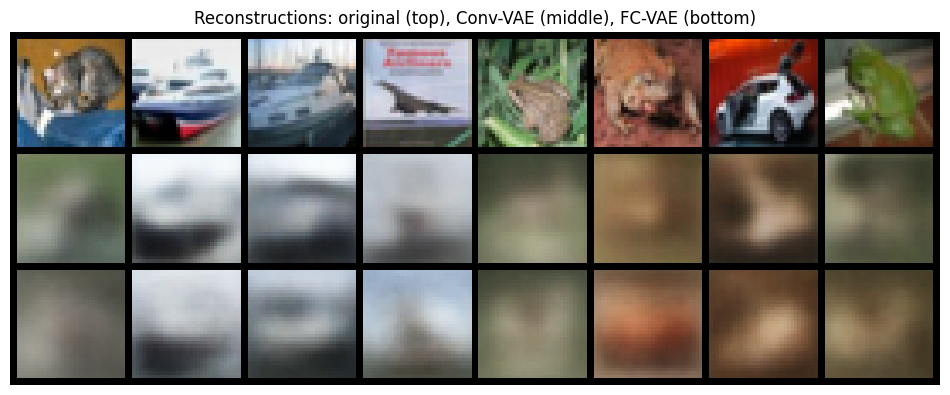

In [ ]:
##### Cell 1.10 — Compare Reconstructions
x, _ = next(iter(test_loader))
x = x[:8].to(device)

recon_conv = reconstruct_images(conv_vae.to(device), x)
recon_fc   = reconstruct_images(fc_vae.to(device),   x)

# 3 rows: original, conv recon, fc recon
triplet = torch.cat([x, recon_conv, recon_fc], dim=0)
show_grid(triplet, title="Reconstructions: original (top), Conv-VAE (middle), FC-VAE (bottom)", nrow=8, figsize=(12,5))


**Results interpresation** <br/>

<br/>

>After implementing a convolutional encoder/decoder to replace the fully connected Variational Autoencoder (VAE) and training both models on the CIFAR-10 dataset, we found promising results that reinforce the idea that convolutional layers can effectively capture spatial relationships, thereby enhancing image quality. The Convolutional VAE (Conv-VAE) demonstrated a significantly lower reconstruction loss—and overall loss—compared to the Fully Connected VAE (FC-VAE), while both models maintained closely aligned training and testing curves. This indicates that the learning process was stable and showed no clear signs of overfitting.

>Visually, the improvements were apparent in the reconstruction comparisons: the Conv-VAE was better at preserving the coarse structure of objects, edges, and spatial layouts, whereas the FC-VAE reconstructions tended to be more washed out and less coherent. This is understandable, as flattening images early in the network can lead to a loss of locality.

>Although both models produced somewhat blurry samples after 10 epochs—something commonly observed with VAEs using pixel-wise reconstruction objectives—the Conv-VAE samples exhibited a more structured and varied appearance. This suggests that convolutional feature hierarchies offer a stronger inductive bias for modeling images, which is likely to lead to higher-quality generations compared to a purely fully connected architecture. Overall, these findings highlight the advantages of convolutional layers in image processing tasks and suggest avenues for further exploration and improvement in VAE design.

### Task2

>Using the trained VAE, interpolate between two images in the latent space and generate intermediate images. This demonstrates how smoothly the model can transition between different data points. Visualize and display the results, showing the interpolated images in a grid format to observe the transformation.

**References / Citations** <br/>
rishabkr. (n.d.). AutoEncoders [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/rishabkr/AutoEncoders

evgiz. (n.d.). variational-autoencoder [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/evgiz/variational-autoencoder


In [ ]:
### Cell 2.1 Helpers (pick endpoints, lerp/slerp, interpolate + visualize)
import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# CIFAR-10 label names (optional, for nicer titles)
CIFAR10_CLASSES = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

def show_grid(images, title="", nrow=8, figsize=(12, 3)):
    """images: Tensor (B,3,32,32) in [0,1]"""
    grid = make_grid(images.cpu(), nrow=nrow, padding=2)
    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(title)
    plt.show()

def pick_two_images_different_classes(dataset, seed=42):
    """Pick two random images from dataset with different class labels."""
    rng = np.random.default_rng(seed)
    idx1 = int(rng.integers(0, len(dataset)))
    x1, y1 = dataset[idx1]
    idx2 = idx1
    while idx2 == idx1:
        idx2 = int(rng.integers(0, len(dataset)))
        x2, y2 = dataset[idx2]
        if y2 != y1:
            break
    return (x1, y1, idx1), (x2, y2, idx2)

def lerp(z1, z2, t):
    """Linear interpolation: (1-t)z1 + t z2"""
    return (1 - t) * z1 + t * z2

def slerp(z1, z2, t, eps=1e-7):
    """
    Spherical linear interpolation.
    Often gives smoother transitions for latent vectors on/near a hypersphere.
    """
    # Normalize
    z1n = z1 / (z1.norm(dim=1, keepdim=True) + eps)
    z2n = z2 / (z2.norm(dim=1, keepdim=True) + eps)

    dot = (z1n * z2n).sum(dim=1, keepdim=True).clamp(-1.0, 1.0)
    omega = torch.acos(dot)               # angle
    sin_omega = torch.sin(omega).clamp_min(eps)

    # If vectors are too close, fallback to lerp
    close = (omega < 1e-3).float()
    part1 = torch.sin((1 - t) * omega) / sin_omega
    part2 = torch.sin(t * omega) / sin_omega
    z = part1 * z1 + part2 * z2
    z_l = lerp(z1, z2, t)

    return close * z_l + (1 - close) * z

@torch.no_grad()
def interpolate_latent(model, x1, x2, steps=10, method="lerp", use_mu=True, device="cuda"):
    """
    model: trained VAE with .encode() and .decode()
    x1, x2: Tensors (3,32,32) in [0,1]
    steps: number of frames INCLUDING endpoints
    method: "lerp" or "slerp"
    use_mu: if True, use encoder mean as latent (deterministic, smoother);
            if False, sample using reparameterization (more stochastic)
    """
    model.eval()
    x = torch.stack([x1, x2]).to(device)

    mu, logvar = model.encode(x)

    if use_mu:
        z1, z2 = mu[0:1], mu[1:2]
    else:
        if hasattr(model, "reparameterize"):
            z = model.reparameterize(mu, logvar)
        else:
            std = torch.exp(0.5 * logvar)
            z = mu + torch.randn_like(std) * std
        z1, z2 = z[0:1], z[1:2]

    ts = torch.linspace(0, 1, steps, device=device).view(-1, 1)  # (steps,1)

    if method.lower() == "slerp":
        zs = torch.cat([slerp(z1, z2, t=ts[i:i+1]) for i in range(steps)], dim=0)
    else:
        zs = lerp(z1, z2, ts)

    imgs = model.decode(zs).clamp(0, 1)  # (steps,3,32,32)
    return imgs


Endpoint A: idx=9449, class=truck (9)
Endpoint B: idx=6250, class=deer (4)


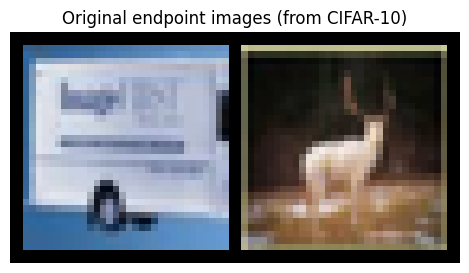

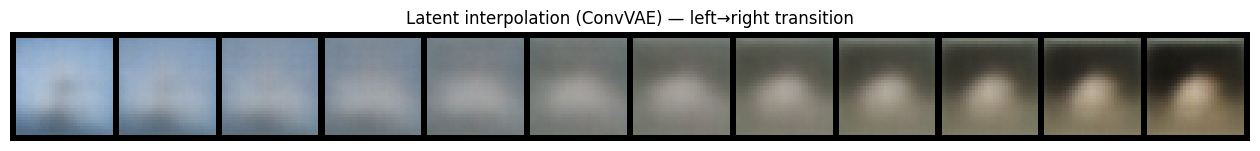

In [ ]:
#### Cell 2.2 Run interpolation using your trained model (Conv-VAE)
# Choose which trained VAE to use:
model_to_use = conv_vae  # <-- recommended for Task 2 (better spatial smoothness)


# Pick two CIFAR-10 images with different labels
(a_img, a_lbl, a_idx), (b_img, b_lbl, b_idx) = pick_two_images_different_classes(test_ds, seed=7)

print(f"Endpoint A: idx={a_idx}, class={CIFAR10_CLASSES[a_lbl]} ({a_lbl})")
print(f"Endpoint B: idx={b_idx}, class={CIFAR10_CLASSES[b_lbl]} ({b_lbl})")

# Show the original endpoints
show_grid(torch.stack([a_img, b_img]), title="Original endpoint images (from CIFAR-10)", nrow=2, figsize=(6,3))

# Interpolate in latent space and decode
STEPS = 12  # number of images in the interpolation grid (includes endpoints)
interp_imgs = interpolate_latent(
    model=model_to_use.to(device),
    x1=a_img,
    x2=b_img,
    steps=STEPS,
    method="lerp",
    use_mu=True,     # deterministic, smoother
    device=device
)

# Visualize interpolation result as a grid (left -> right transition)
show_grid(interp_imgs, title=f"Latent interpolation ({model_to_use.__class__.__name__}) — left→right transition", nrow=STEPS, figsize=(16,3))


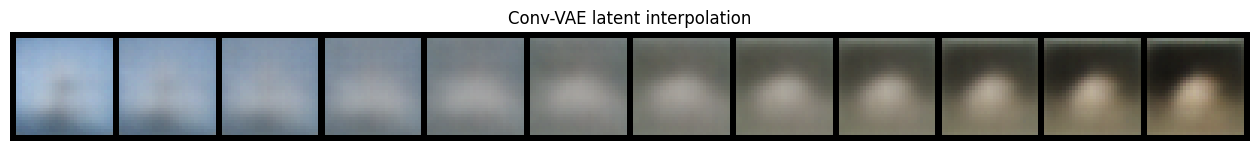

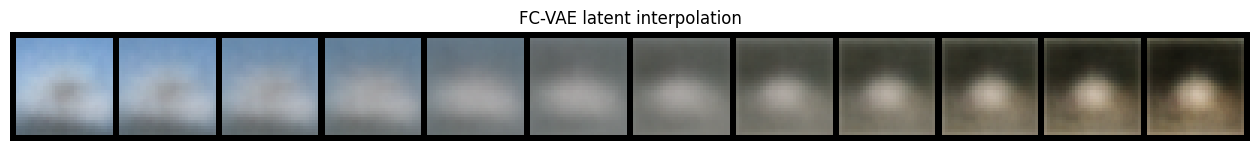

In [ ]:
#### Cell 2.3 Compare Conv-VAE vs FC-VAE interpolation side-by-side
STEPS = 12

interp_conv = interpolate_latent(conv_vae.to(device), a_img, b_img, steps=STEPS, method="lerp", use_mu=True, device=device)
interp_fc   = interpolate_latent(fc_vae.to(device),   a_img, b_img, steps=STEPS, method="lerp", use_mu=True, device=device)

show_grid(interp_conv, title="Conv-VAE latent interpolation", nrow=STEPS, figsize=(16,3))
show_grid(interp_fc,   title="FC-VAE latent interpolation",   nrow=STEPS, figsize=(16,3))


Note:
>Interpolation is done in the latent space between two encoded points, producing intermediate latent vectors.

>Decoding those vectors shows whether the learned latent space is smooth: adjacent frames should change gradually rather than jump.

**Results interpresation** <br/>

<br/>

>In sections B (2.2) and C (2.3), latent-space interpolation indicates that the Variational Autoencoder (VAE) learned a relatively smooth latent structure for CIFAR-10 images. As the latent representation transitions from the “truck” endpoint to the “deer” endpoint, the decoded outputs change gradually without abrupt discontinuities. This suggests that nearby points in the latent space map to visually similar images, consistent with a smooth latent manifold.

>Notably, the Conv-VAE produces more spatially consistent intermediate images during interpolation. Coarse shapes and background color regions evolve more smoothly and preserve a clearer overall layout, reflecting the convolutional encoder/decoder’s ability to retain local and hierarchical spatial features. In contrast, the FC-VAE interpolation appears more washed out and less structured, which is expected when images are flattened and spatial relationships are not modeled explicitly.

>Using β = 1.5 increases the weight of the KL term, encouraging the latent distribution to remain closer to the standard normal prior. This typically promotes a smoother, more regular latent space, but it can also reduce sharpness and yield blurrier, more “average” outputs. In our results, the Conv‑VAE still preserves more coherent structure than the FC‑VAE under this stronger regularization, suggesting that convolutional inductive bias remains beneficial even with increased KL pressure.

>Overall, while some blurriness remains, common for VAEs trained with pixel-wise reconstruction losses, the Conv‑VAE interpolation demonstrates better preservation of spatial relationships and more coherent intermediate images than the fully connected VAE.



### Task3

>Train the VAE on a new dataset of your choice (e.g., CelebA for faces), and visualize generated samples. Experiment with sampling from different regions of the latent space and analyze how the generated outputs vary based on different latent vectors.

References / Citations <br/> <br/>
- AntixK. (n.d.). PyTorch-VAE [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/AntixK/PyTorch-VAE

- moshesipper. (n.d.). vae-torch-celeba [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/moshesipper/vae-torch-celeba

- bhpfelix. (n.d.). Variational-Autoencoder-PyTorch [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/bhpfelix/Variational-Autoencoder-PyTorch

- julian-8897. (n.d.). conv-vae-pytorch [GitHub repository]. GitHub. Retrieved January 31, 2026, from https://github.com/julian-8897/conv-vae-pytorch


In [26]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

import os

ZIP_PATH = "/content/drive/MyDrive/DS552_CS552_Generative_Artificial_Intelligence/Assignment_3_Variational_Autoencoders_VAEs/data/img_align_celeba.zip"

print("ZIP_PATH:", ZIP_PATH)
print("Exists?", os.path.exists(ZIP_PATH))

if os.path.exists(ZIP_PATH):
    print("File size (MB):", os.path.getsize(ZIP_PATH) / (1024**2))
else:
    print("❌ File not found — path is wrong or Drive not mounted")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP_PATH: /content/drive/MyDrive/DS552_CS552_Generative_Artificial_Intelligence/Assignment_3_Variational_Autoencoders_VAEs/data/img_align_celeba.zip
Exists? True
File size (MB): 1376.620138168335


Images already extracted: ./data/celeba_images/img_align_celeba
Train size: 182340 Valid size: 20259


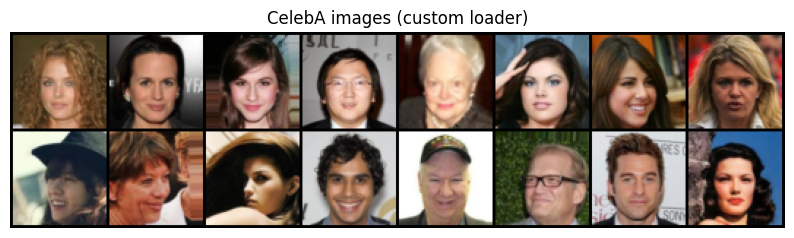

In [27]:
#### Cell 3.1 — Setup (imports, seed, device)
import zipfile
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, random_split

# Unzip once (if not already extracted)
IMG_DIR = os.path.join("./data", "celeba_images", "img_align_celeba")
ZIP_PATH = "/content/drive/MyDrive/DS552_CS552_Generative_Artificial_Intelligence/Assignment_3_Variational_Autoencoders_VAEs/data/img_align_celeba.zip"  # <-- adjust

os.makedirs(os.path.dirname(IMG_DIR), exist_ok=True)
if not os.path.exists(IMG_DIR) or len(os.listdir(IMG_DIR)) == 0:
    print("Extracting CelebA images...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(os.path.join("./data", "celeba_images"))
else:
    print("Images already extracted:", IMG_DIR)

class FlatImageFolder(Dataset):
    def __init__(self, img_dir, transform=None, max_items=None):
        self.paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
        if max_items is not None:
            self.paths = self.paths[:max_items]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

dataset = FlatImageFolder(IMG_DIR, transform=transform)

# Make your own split
val_frac = 0.1
n_val = int(len(dataset) * val_frac)
n_train = len(dataset) - n_val

train_ds, valid_ds = random_split(
    dataset, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=(device.type=="cuda"))
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(device.type=="cuda"))

print("Train size:", len(train_ds), "Valid size:", len(valid_ds))

x0, _ = next(iter(train_loader))
show_grid(x0[:16], title="CelebA images (custom loader)", nrow=8, figsize=(10,5))


Images already extracted: ./data/celeba_images/img_align_celeba
Train size: 182340 | Valid size: 20259


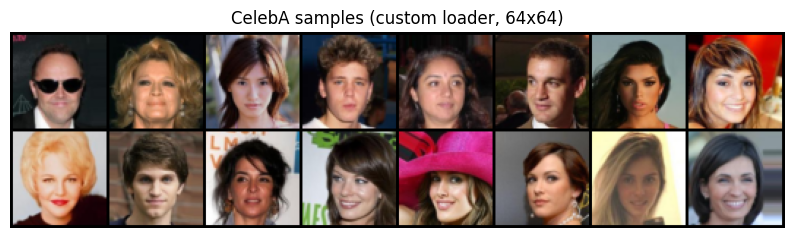

In [28]:
# Cell 3.2 — Load CelebA (faces) from local ZIP (no torchvision download)

import os, zipfile
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as T

# --- Config ---
IMG_SIZE = 64
BATCH_SIZE = 128  # if OOM, try 64
NUM_WORKERS = 0   # recommended in Colab (avoids multiprocessing shutdown noise)

MAX_IMAGES = None  # optional quick run: e.g., 50000 (uses only first N images after extraction)

transform = T.Compose([
    T.CenterCrop(178),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

# Your Drive zip path (works for you already)
ZIP_PATH = "/content/drive/MyDrive/DS552_CS552_Generative_Artificial_Intelligence/Assignment_3_Variational_Autoencoders_VAEs/data/img_align_celeba.zip"

# Extract destination
IMG_DIR = os.path.join("./data", "celeba_images", "img_align_celeba")
os.makedirs(os.path.dirname(IMG_DIR), exist_ok=True)

# Extract once
if not os.path.exists(IMG_DIR) or len(os.listdir(IMG_DIR)) == 0:
    print("Extracting CelebA images...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(os.path.join("./data", "celeba_images"))
else:
    print("Images already extracted:", IMG_DIR)

class FlatImageFolder(Dataset):
    def __init__(self, img_dir, transform=None, max_items=None):
        self.paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
        if max_items is not None:
            self.paths = self.paths[:max_items]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label (VAE doesn't need labels)

dataset = FlatImageFolder(IMG_DIR, transform=transform, max_items=MAX_IMAGES)

# Make your own split (90/10)
val_frac = 0.1
n_val = int(len(dataset) * val_frac)
n_train = len(dataset) - n_val

train_ds, valid_ds = random_split(
    dataset, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda")
)
valid_loader = DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda")
)

print("Train size:", len(train_ds), "| Valid size:", len(valid_ds))

# Quick visual sanity-check
x0, _ = next(iter(train_loader))
show_grid(x0[:16], title="CelebA samples (custom loader, 64x64)", nrow=8, figsize=(10,5))


In [29]:
#### Cell 3.3 — Conv-VAE for 64×64
class ConvVAE64(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim

        # 64 -> 32 -> 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # (B,32,32,32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1),  # (B,64,16,16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1), # (B,128,8,8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),# (B,256,4,4)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.enc_out_dim = 256 * 4 * 4
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, self.enc_out_dim)

        # 4 -> 8 -> 16 -> 32 -> 64
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (B,128,8,8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (B,64,16,16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (B,32,32,32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # (B,3,64,64)
            nn.Sigmoid(),                           # output in [0,1]
        )

    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(z.size(0), 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
#### Cell 3.4 — Loss + Training Loop
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def recon_loss_fn(recon_x, x, kind="mse"):
    # sum over batch+pixels
    if kind == "bce":
        return F.binary_cross_entropy(recon_x, x, reduction="sum")
    return F.mse_loss(recon_x, x, reduction="sum")

def vae_loss(recon_x, x, mu, logvar, beta=1.0, recon_kind="mse"):
    recon = recon_loss_fn(recon_x, x, kind=recon_kind)
    kl = kl_divergence(mu, logvar)
    total = recon + beta * kl
    bs = x.size(0)
    return total / bs, recon / bs, kl / bs

def train_vae(model, train_loader, valid_loader, epochs=10, lr=2e-4, beta=1.0, recon_kind="mse"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    use_amp = (device.type == "cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    history = {"train_total": [], "train_recon": [], "train_kl": [],
               "valid_total": [], "valid_recon": [], "valid_kl": []}

    for epoch in range(1, epochs + 1):
        # ---- train ----
        model.train()
        t_total = t_recon = t_kl = 0.0
        n_train = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]", leave=False)
        for x, _ in pbar:
            x = x.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                recon, mu, logvar = model(x)
                loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta=beta, recon_kind=recon_kind)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            bs = x.size(0)
            t_total += loss.item() * bs
            t_recon += rloss.item() * bs
            t_kl += kl.item() * bs
            n_train += bs
            pbar.set_postfix({"loss": loss.item(), "recon": rloss.item(), "kl": kl.item()})

        # ---- valid ----
        model.eval()
        v_total = v_recon = v_kl = 0.0
        n_valid = 0
        with torch.no_grad():
            for x, _ in tqdm(valid_loader, desc=f"Epoch {epoch}/{epochs} [valid]", leave=False):
                x = x.to(device, non_blocking=True)
                recon, mu, logvar = model(x)
                loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta=beta, recon_kind=recon_kind)

                bs = x.size(0)
                v_total += loss.item() * bs
                v_recon += rloss.item() * bs
                v_kl += kl.item() * bs
                n_valid += bs

        train_total = t_total / n_train
        train_recon = t_recon / n_train
        train_kl = t_kl / n_train

        valid_total = v_total / n_valid
        valid_recon = v_recon / n_valid
        valid_kl = v_kl / n_valid

        history["train_total"].append(train_total)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)

        history["valid_total"].append(valid_total)
        history["valid_recon"].append(valid_recon)
        history["valid_kl"].append(valid_kl)

        print(
            f"Epoch {epoch:02d}/{epochs} | "
            f"Train total={train_total:.4f} recon={train_recon:.4f} kl={train_kl:.4f} | "
            f"Valid total={valid_total:.4f} recon={valid_recon:.4f} kl={valid_kl:.4f}"
        )

    return history


/tmp/ipython-input-3623721387.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Epoch 1/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

/tmp/ipython-input-3623721387.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 01/10 | Train total=270.9841 recon=212.8377 kl=58.1464 | Valid total=208.1750 recon=147.4157 kl=60.7593


Epoch 2/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 2/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 02/10 | Train total=201.6634 recon=140.3166 kl=61.3468 | Valid total=197.4837 recon=134.7988 kl=62.6850


Epoch 3/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 3/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 03/10 | Train total=194.3585 recon=132.3120 kl=62.0465 | Valid total=191.6297 recon=129.3513 kl=62.2785


Epoch 4/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 4/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 04/10 | Train total=190.4936 recon=128.2034 kl=62.2902 | Valid total=187.7902 recon=124.5183 kl=63.2719


Epoch 5/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 5/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 05/10 | Train total=187.9731 recon=125.5713 kl=62.4018 | Valid total=187.2936 recon=124.4094 kl=62.8842


Epoch 6/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 6/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 06/10 | Train total=186.1303 recon=123.6210 kl=62.5094 | Valid total=184.6971 recon=122.6068 kl=62.0903


Epoch 7/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 7/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 07/10 | Train total=184.6992 recon=122.1345 kl=62.5647 | Valid total=184.0491 recon=121.2157 kl=62.8334


Epoch 8/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 8/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 08/10 | Train total=183.5224 recon=120.9248 kl=62.5975 | Valid total=182.9543 recon=119.8686 kl=63.0857


Epoch 9/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 9/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 09/10 | Train total=182.4544 recon=119.8388 kl=62.6157 | Valid total=181.0061 recon=118.6620 kl=62.3441


Epoch 10/10 [train]:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 10/10 [valid]:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch 10/10 | Train total=181.5021 recon=118.7423 kl=62.7598 | Valid total=180.3628 recon=117.6641 kl=62.6987


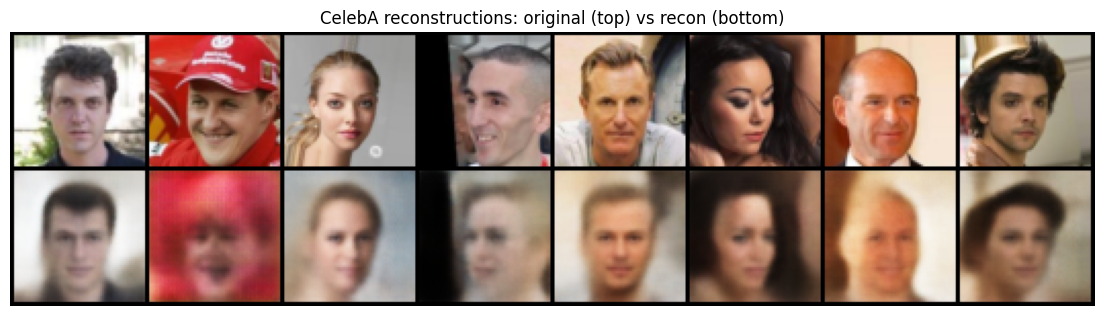

In [31]:
#### Cell 3.5 — Train on CelebA + quick reconstructions


LATENT_DIM = 128
EPOCHS = 10       # 10 for this assigment
LR = 2e-4
BETA = 1.0
RECON = "mse"

celeba_vae = ConvVAE64(latent_dim=LATENT_DIM).to(device)

hist_celeba = train_vae(
    celeba_vae, train_loader, valid_loader,
    epochs=EPOCHS, lr=LR, beta=BETA, recon_kind=RECON
)

# (Sanity check) Save weights so we don’t lose training when Colab resets
torch.save(
    {"state_dict": celeba_vae.state_dict(), "latent_dim": LATENT_DIM},
    "celeba_convvae64.pt"
)

# Reconstructions on a validation batch (use inference_mode for speed)
celeba_vae.eval()
xv, _ = next(iter(valid_loader))
xv = xv.to(device)[:8]

with torch.inference_mode():
    recon, _, _ = celeba_vae(xv)

viz = torch.cat([xv, recon.clamp(0, 1)], dim=0)
show_grid(viz, title="CelebA reconstructions: original (top) vs recon (bottom)", nrow=8, figsize=(14,4))



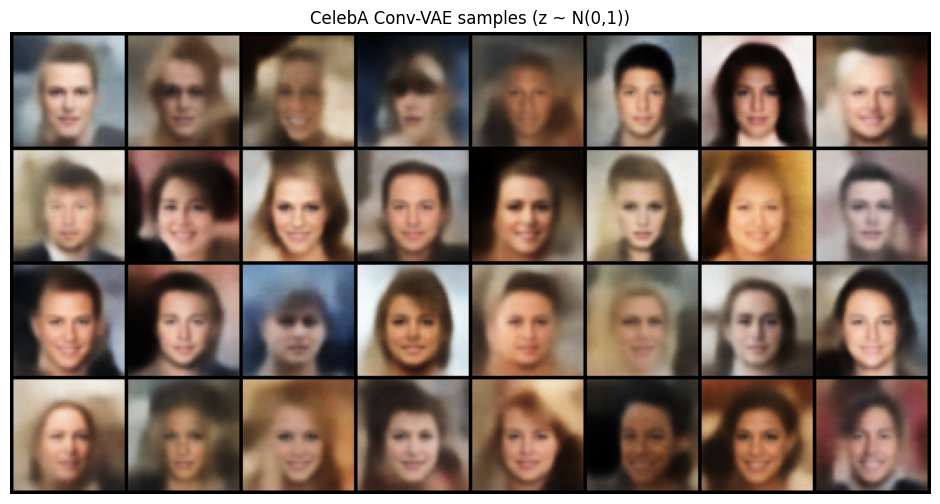

In [32]:
#### Cell 3.6 — Generate samples from the prior
@torch.no_grad()
def sample_prior(model, latent_dim, n=16, scale=1.0):
    model.eval()
    z = torch.randn(n, latent_dim, device=device) * scale
    x = model.decode(z).clamp(0, 1)
    return x

samples = sample_prior(celeba_vae.to(device), LATENT_DIM, n=32, scale=1.0)
show_grid(samples, title="CelebA Conv-VAE samples (z ~ N(0,1))", nrow=8, figsize=(12,6))



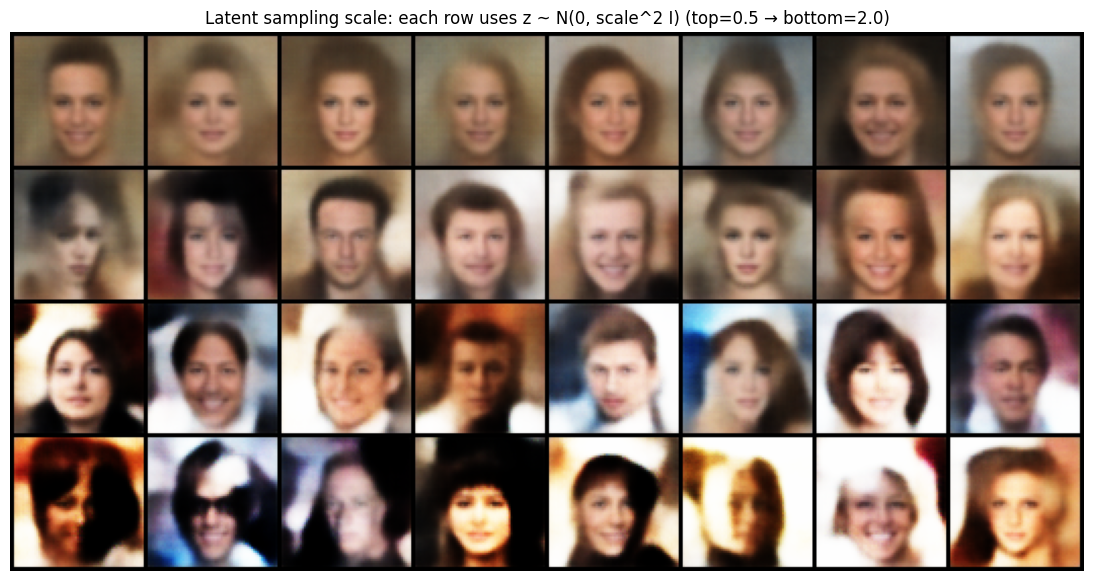

In [33]:
#### Cell 3.7 — Explore “different regions” of the latent space
#“Temperature” / scale sampling (near vs far from origin)
scales = [0.5, 1.0, 1.5, 2.0]
rows = []
for s in scales:
    rows.append(sample_prior(celeba_vae.to(device), LATENT_DIM, n=8, scale=s))
grid = torch.cat(rows, dim=0)

show_grid(
    grid,
    title="Latent sampling scale: each row uses z ~ N(0, scale^2 I) (top=0.5 → bottom=2.0)",
    nrow=8,
    figsize=(14,7)
)


Cell 3.7 Analysis latent "temperatur" / scale sampling
>Each row samples
𝑧
∼
𝑁
(
0
,
scale
2
𝐼
)
z∼N(0,scale
2
I), so larger scale moves latent points farther from the origin. At scale = 0.5, faces look more consistent and “average,” reflecting sampling from high-density latent regions. At scale = 1.0–1.5, outputs become more diverse (hair, shape, lighting) while still face-like. At scale = 2.0, images show more blur and artifacts, suggesting off-manifold sampling. Overall, smaller scales give higher quality but less variety, while larger scales increase diversity at the cost of realism.

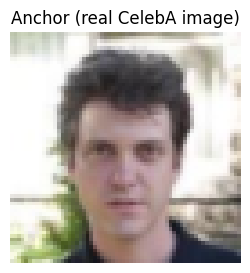

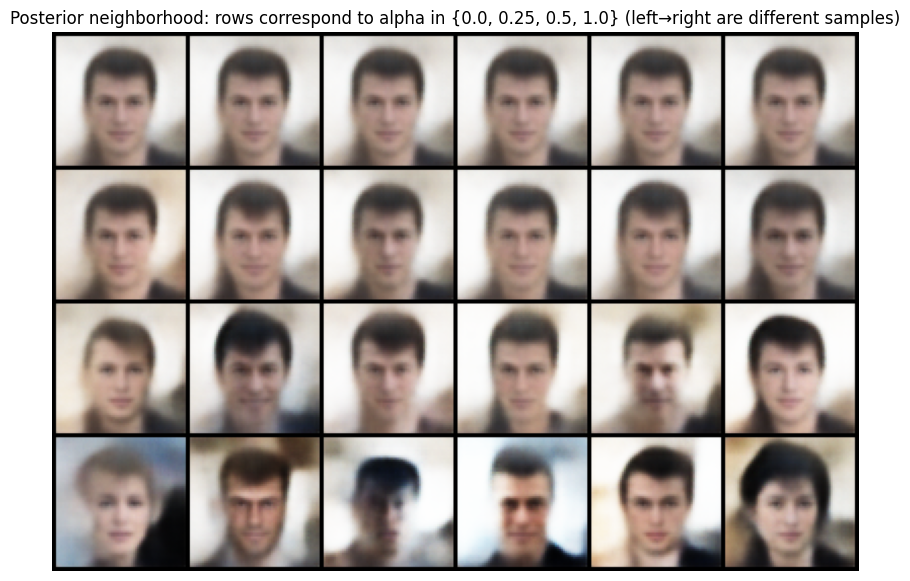

In [34]:
#### Cell 3.8 — Posterior neighborhood sampling (around a real image)
@torch.no_grad()
def posterior_neighborhood(model, x, alphas=(0.0, 0.25, 0.5, 1.0), n_per_alpha=6):
    model.eval()
    x = x.unsqueeze(0).to(device)  # (1,3,64,64)
    mu, logvar = model.encode(x)

    out = []
    for a in alphas:
        eps = torch.randn(n_per_alpha, mu.size(1), device=device)
        z = mu.repeat(n_per_alpha, 1) + a * eps
        imgs = model.decode(z).clamp(0,1)
        out.append(imgs)
    return torch.cat(out, dim=0)

# grab a single validation image
xv, _ = next(iter(valid_loader))
x_anchor = xv[0]

# show the anchor image
show_grid(x_anchor.unsqueeze(0), title="Anchor (real CelebA image)", nrow=1, figsize=(3,3))

alphas = (0.0, 0.25, 0.5, 1.0)
neigh = posterior_neighborhood(celeba_vae.to(device), x_anchor, alphas=alphas, n_per_alpha=6)

show_grid(
    neigh,
    title="Posterior neighborhood: rows correspond to alpha in {0.0, 0.25, 0.5, 1.0} (left→right are different samples)",
    nrow=6,
    figsize=(14,7)
)


Cell 3.7.2 — Posterior neighborhood sampling (around a real image) Interpretation
>The posterior-neighborhood sampling results show how the Conv‑VAE behaves when decoding latent codes near a real CelebA example. At α = 0, decoding the mean latent vector μ produces essentially the same “reconstruction-like” face each time, acting as a stable prototype of the anchor. As α increases to 0.25 and 0.5, adding small amounts of noise generates plausible variations that largely preserve the overall identity and structure (minor changes in hair shape, lighting, and background tone), indicating the latent space is locally smooth—nearby latent points decode to similar images. At α = 1.0, variation becomes much stronger and samples begin to drift away from the anchor’s identity and may show more artifacts, consistent with moving farther from the local neighborhood around μ. Overall, the grid demonstrates that the VAE supports smooth, continuous changes in image space for small latent perturbations, while larger perturbations increase diversity at the cost of identity consistency and realism.

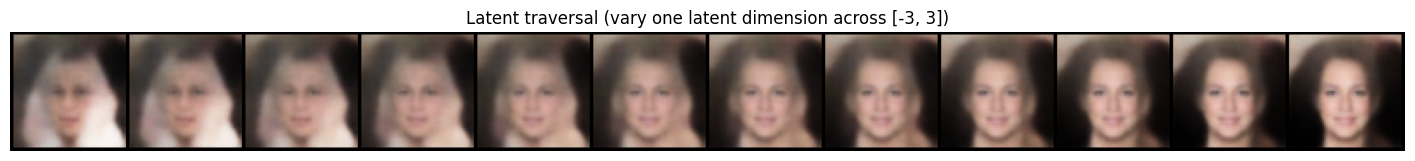

In [35]:
#### Cell 3.9 — Latent traversal (move along one latent dimension)
@torch.no_grad()
def latent_traversal(model, latent_dim, dim=0, n_steps=12, span=3.0):
    model.eval()
    z0 = torch.randn(1, latent_dim, device=device)
    values = torch.linspace(-span, span, n_steps, device=device)

    zs = z0.repeat(n_steps, 1)
    zs[:, dim] = values
    imgs = model.decode(zs).clamp(0, 1)
    return imgs

trav = latent_traversal(celeba_vae.to(device), LATENT_DIM, dim=0, n_steps=12, span=3.0)
show_grid(trav, title="Latent traversal (vary one latent dimension across [-3, 3])", nrow=12, figsize=(18,3))


Cell 3.7.3 — Latent traversal Analysis Results
>Cell varies one latent dimension from
−
3
−3 to
3
3 while keeping all others fixed, then decodes each step. The resulting strip changes smoothly left→right (no abrupt jumps), showing the latent space is continuous. In the resulting output, the identity stays mostly the same and changes are subtle (mainly lighting/background and soft facial details), suggesting this dimension controls a weak or entangled factor rather than a clearly separable attribute—common in a standard VAE.